## Overview
- Pearson correlation calculation and implementation
- Discretisation preprocessing
- Mutual Information (MI) and NMI calculation and implementation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import normalized_mutual_info_score

## Pearson Correlation Coefficient

Requirements/Assumptions for using the Pearson's correlation coefficient:
- Scale of measurement should be an interval or ratio.
- Variables should be approximately normally distributed if a significance test is to be trusted.
- The association should be linear (can be confirmed using a visualisation).

Correlation is best suited to *continuous*, *normally distributed* data and is thus easily swayed by extreme values. As such, correlation will misrepresent relationships that are non-linear and/or non-continuous. In an example, the relationship between `time_on_site` and `quantity` is non-linear. However, the calculated correlation value misrepresents the relationship between them.

## Formula and Derivation
Given paired data ${\displaystyle \left\{(x_{1},y_{1}),\ldots ,(x_{n},y_{n})\right\}}$  pairs, perason correlation coefficient ${\displaystyle r_{xy}}$ between them is defined as:

$${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}  (Eq. 1) $$ 
where: 

- ${\displaystyle n}$ is sample size 
- ${\displaystyle x_{i},y_{i}}$ are the individual sample points indexed with $i$
- ${\textstyle {\bar {x}}={\frac {1}{n}}\sum _{i=1}^{n}x_{i}}$ is the  sample mean 

In [2]:
data = pd.read_csv('week06_correlation.csv')
data.head()

,unit_price,movie_rating,time_on_site,quantity,label
0,25,6.98,129.402179,3,Low
1,25,8.09,96.931070,3,Low
2,25,7.56,102.937014,1,Low
3,25,6.83,127.514061,4,Low
4,20,6.34,152.369508,5,Low


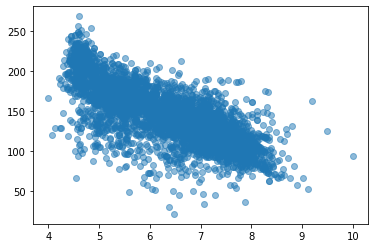

In [3]:
plt.scatter(x=data['movie_rating'], y=data['time_on_site'], alpha=0.5)
#Check for linear relationship
plt.show()

In [4]:
def pearson_r(feature_a, feature_b):
    """
    A function which computes the Pearson Correlation between two features
    """
    # compute the mean
    mean_a = feature_a.mean()
    mean_b = feature_b.mean()
    
    # compute the numerator of pearson r
    numerator = sum((feature_a - mean_a) * (feature_b - mean_b))
    
    # compute the denominator of pearson r
    denominator = np.sqrt(sum((feature_a - mean_a) ** 2) * sum((feature_b - mean_b) ** 2))
    
    return numerator/denominator

In [5]:
r = pearson_r(data['movie_rating'], data['time_on_site'])
print(f"{r:.4f}")

-0.7608


In [6]:
FEATURES = ['movie_rating', 'time_on_site']

data[FEATURES].corr(method='pearson')

,movie_rating,time_on_site
movie_rating,1.00000,-0.76076
time_on_site,-0.76076,1.00000


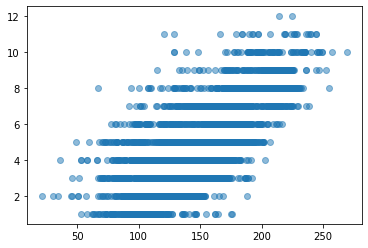

In [7]:
# Visual check to see that the 2 variables are not linearly correlated
plt.scatter(data['time_on_site'], data['quantity'], alpha=0.5)

plt.show()

In [8]:
# Calculate Pearson's r to see that it's suggesting a positive linear correlation
INCORRECT_FEATURES = ['time_on_site', 'quantity']

data[INCORRECT_FEATURES].corr(method='pearson')

,time_on_site,quantity
time_on_site,1.000000,0.763127
quantity,0.763127,1.000000


In these cases where Pearson's r is not an appropriate measure of correlation, we can use the Mutual Information (MI) score as a correlation metric instead. However, we need the variables to be converted into discrete variables, via Discretization.

## Discretization
Discretization is the process through which we can transform continuous variables into a discrete form. 

- We do this by creating a set of intervals (better known as **bins**) that go across the range or frequency of our desired variable. 

We will now learn two methods of discrerization on continuous variable.

## Discretization via Domain Knowledge
- Domain Knowledge is known as the "business context" or "background context" behind the dataset.
- Whilst numbers can tell you a lot of information, it is always good to refer back to the actual meaning behind the dataset.

First we will discretize the continuous variable `quantity` into 3 bins based on our "domain knowledge". 

In [9]:
def bin_quantity(x):
    """
    Domain knowledge oriented discretization with the following bins:
    
        [min, 5), [5, 10), [10, max] 
        
    Remeber that [] denote inclusive, () denote exclusive.
    """
    LOWER = 5
    UPPER = 10
    
    # [min, 5)
    if x < LOWER:
        return 0
    # [5, 10)
    elif LOWER <= x < UPPER:
        return 1 
    # [10, max] 
    return 2

# apply the function on the series
data['binned_quantity'] = data['quantity'].apply(bin_quantity)

# also, print out the min/max for this feature
min(data['quantity']), max(data['quantity'])

(1, 12)

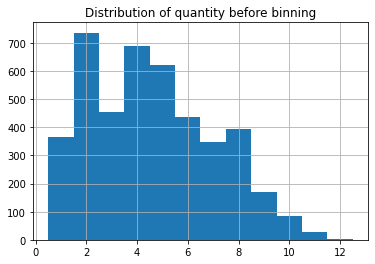

In [10]:
data['quantity'].hist(bins=np.arange(13)+0.5)

plt.title('Distribution of quantity before binning')

plt.show()

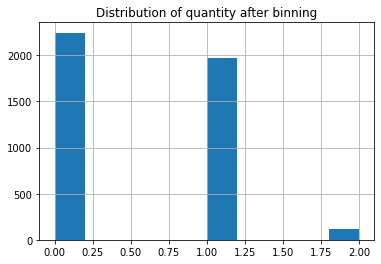

In [11]:
data['binned_quantity'].hist()

plt.title('Distribution of quantity after binning')

plt.show()

You'll notice above that the bins are now looking a bit sparse. That's expected since we discretized our values into 0, 1, and 2.

In order to make it look a "bit nicer", we can specify `bins=3` to denote the width.

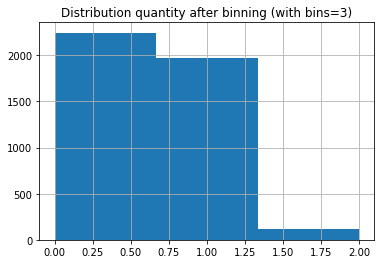

In [12]:
data.hist('binned_quantity', bins=3)

plt.title('Distribution quantity after binning (with bins=3)')

plt.show()

## Discretization via Binning

In [13]:
equal_width = KBinsDiscretizer(n_bins=3,
                               encode='ordinal', 
                               strategy='uniform')

# a transformed version of 
data['binned_time_on_site'] = equal_width.fit_transform(data[['time_on_site']]).astype(int)

In [14]:
# look at a sample of the data
data[['time_on_site', 'binned_time_on_site']].head(10)

,time_on_site,binned_time_on_site
0,129.402179,1
1,96.931070,0
2,102.937014,0
3,127.514061,1
4,152.369508,1
5,129.696410,1
6,154.175174,1
7,189.422895,2
8,167.208314,1
9,180.088347,1


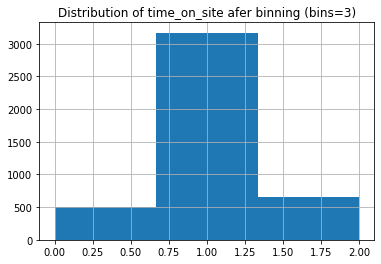

In [15]:
data['binned_time_on_site'].hist(bins=3)

plt.title('Distribution of time_on_site afer binning (bins=3)')

plt.show()

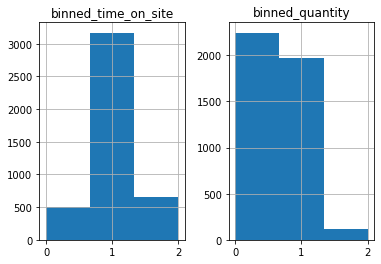

In [16]:
data.hist(column=['binned_time_on_site', 'binned_quantity'], bins=3)

plt.show()

## Entropy
Entropy is the amount of _information_ or _uncertainty_ in some variables' possible outcome. For example:
- An unbiased coin flip (50% Heads, 50% Tails) will have an entropy of 1. 
- A biased coin flip (100% Heads, 0% Tails) will have an entropy of 0. 
    
From above, hopefully you can see that the entropy is 1 with the unbiased coin flip because there is one _uncertainty_ in the flip (either heads or tails). Likewise, in the biased coin flip, we have no _uncertainty_ (100% certain we are getting Heads), hence, the entropy is 0.
    
It originates from Shannon's Entropy (which is to do with bits in networking), hence, the reason why you should be using the logarithm base 2 when doing calculations.
    
The entropy is given to you as:
    
$$
H(X) = -\sum P(X=x_i)\log_2(P(X=x_i)) 
$$
    
1. $P(X=x_i)$ represents the event $x_i$ occurring.
2. For binning, $P(X=x_i)$ specifically represents the probability of a data value belonging to a specific bin.
    
## <u> Concept: Conditional Entropy </u>
The conditional entropy is the amount of _information_ to describe an outcome of $Y$ given that $X$ occurred.
    - It's good to know that if $Y$ is completely determined by $X$, then $H(Y|X)=0$.
    
    
The conditional entropy is given to you as:
    
$$
H(Y|X) = \sum_{x_i \in X} P(X=x_i) H(Y|X=x_i),
$$

where $H(Y|X=x)$ means calculating the entropy of the distribution $P(Y|X=x)$:

$$H(Y|X=x) = -\sum_{y_j \in Y} P(Y=y_j|X=x)\log_2(P(Y=y_j|X=x)).$$
    
The conditional entropy of $Y$ given $X$ is the probability of $x_i$ occurring _times_ the entropy of $Y$ given that $x_i$ occurred. 
- You can think of it as "locking" or "fixing" the condition on event $x_i$, then compute $Y$ with the remaining values.

## <u> Concept: Mutual Information (MI) </u>
Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable. It is considered more general than correlation and handles non-linear dependencies and discrete random variables.

In other words:
* It is the amount of _dependence_ between two random variables.
* The larger the MI, the more dependent or correlated they are.
* In contrast, the greater the _entropy_, the more _uncertain_ we are. 


The mutual information between two random variables $X$ and $Y$ can be stated formally as follows:

$$
\text{MI}(X, Y) = H(X) – H(X | Y) = H(Y) - H(Y | X)
$$
where
- $\text{MI}(X, Y)$ is the mutual information for $X$ and $Y$
- $H(X)$ is the entropy for $X$ 
- $H(X|Y)$ is the conditional entropy for $X$ given $Y$. 

_Normalized Mutual Information (NMI)_ is a normalization of MI to scale the results between 0 (no mutual information) and 1 (perfect correlation). It is computed using the following formula:

$$
\text{NMI}(X, Y) = \frac{\text{MI}(X,Y)}{min(H(X),H(Y))}
$$
where
- $\text{MI}(X,Y)$ is the mutual information for $X$ and $Y$
- $H(X)$ is the entropy for $X$ 
- $H(Y)$ is the entropy for $Y$ 




In [17]:
def compute_probability(col):
    """
    Compute the probability of a certain event
    """
    return col.value_counts() / col.shape[0]

def compute_entropy(col):
    """
    Compute the entropy of a certain event
    """
    probabilities = compute_probability(col)
    entropy = -sum(probabilities * np.log2(probabilities))
    return entropy

In [18]:
# for the binned quantity
print("Probabilities")
print(compute_probability(data['binned_quantity']))
print("\nEntropy for binned_quantity")
print(compute_entropy(data['binned_quantity']))

Probabilities
0    0.519075
1    0.455029
2    0.025896
Name: binned_quantity, dtype: float64

Entropy for binned_quantity
1.1444372056671537


In [19]:
# for binned time on site
print(compute_entropy(data['binned_time_on_site']))

1.1015470420424556


In [20]:
def compute_conditional_entropy(x, y):
    """
    Compute the conditional entropy between two random variables.
    Specifically, the conditional entropy of Y given X.
    """
    probability_x = compute_probability(x)
    
    temp_df = pd.DataFrame({'X': x, 'Y': y})
    
    entropy_by_group = temp_df.groupby('X')['Y'].aggregate(compute_entropy)
    conditional_entropy = sum(probability_x * entropy_by_group)
    
    return conditional_entropy

print(compute_conditional_entropy(data['binned_time_on_site'], data['binned_quantity']))
print(compute_conditional_entropy(data['binned_quantity'], data['binned_time_on_site']))

0.929206354118664
0.8863161904939663


In [21]:
def NMI(x, y):
    """
    Compute the NMI between two random variables
    """
    # H(X) and H(Y)
    entropy_x = compute_entropy(x)
    entropy_y = compute_entropy(y)
    
    # H(Y|X)
    conditional_entropy = compute_conditional_entropy(x, y)
    
    # MI(X, Y)
    MI = entropy_y - conditional_entropy 
    # same as MI = entropy_x - compute_conditional_entropy(y, x)
    
    return MI / min(entropy_x, entropy_y)

print(NMI(data['binned_time_on_site'], data['binned_quantity']))

0.19538961418244566


In [22]:
normalized_mutual_info_score(data['binned_time_on_site'], 
                             data['binned_quantity'], 
                             
                             # we use min here because in NMI, we want to have our demoninator
                             # to be min(H(X), H(Y))
                             average_method='min')

0.1953896141824446